In [1]:
from imports import *
from ChannelShape import *
import matplotlib.animation as animation
%matplotlib inline

Welcome to JupyROOT 6.28/10


In [2]:
# Define channel shapes for CDMSlite detector
# Done here manually rather than loading from a DMC file
litechan = DetectorShape("CDMSlite1")
litechan.Add(ChannelShape("PA",1,31.3,36.1,-pi,pi,+1.,0., 0., 29.60, 34.75))
litechan.Add(ChannelShape("PB",1,0.,31.3,radians(90.),radians(210.),+1., 0., 0., 0., 29.60))
litechan.Add(ChannelShape("PC",1,0.,31.3,radians(210.),radians(330.),+1., 0., 0., 0., 29.60))
litechan.Add(ChannelShape("PD",1,0.,31.3,radians(-30.),radians(90.),+1., 0., 0., 0., 29.60))
litechan.Add(ChannelShape("Det",None,0.,38.1,-pi,pi,+1., 0., 75.4888/2., 0., 72.1868/2.).addFlat(37.7444,radians(45.)))
# NOTE: In CDMSZipInfo, X and Y flats are given by diameter, not radius

{'PA': <ChannelShape('PA',1,31.3,36.1,-3.141592653589793,3.141592653589793,1.0)>,
 'PB': <ChannelShape('PB',1,0.0,31.3,1.5707963267948966,-2.617993877991494,1.0)>,
 'PC': <ChannelShape('PC',1,0.0,31.3,-2.617993877991494,-0.5235987755982991,1.0)>,
 'PD': <ChannelShape('PD',1,0.0,31.3,-0.5235987755982988,1.5707963267948966,1.0)>,
 'Det': <ChannelShape('Det',None,0.0,38.1,-3.141592653589793,3.141592653589793,1.0)>}

In [3]:
# Draw detector outline, including flats
def drawDet(detShape):
    """Use specified detector (DetectorShape class) to draw the outline of the
       detector, for further annotation."""
    phi = np.arange(1000)*2.*pi/1000.
    edge = [detShape.getPointAtPhi(f) for f in phi]
    rlim = 1.1*detShape["Det"].rmax
    
    plt.figure(figsize=(6,6))    # Units are inches
    plt.plot(*zip(*edge))
    plt.axis('square')

In [4]:
# Need some basic 2D vector operations
def vlen(vec):
    return sqrt(vec[0]**2+vec[1]**2)

def vdot(v1,v2):
    return (v1[0]*v2[0]+v1[1]*v2[1])

def vsum(v1,v2):
    return (v1[0]+v2[0], v1[1]+v2[1])

def vdiff(v1,v2):
    return (v1[0]-v2[0], v1[1]-v2[1])

def vmult(vec, val):
    return (val*vec[0],val*vec[1])

In [5]:
def reflectPoint(pos, center, detShape):
    """Use specified detector outline (DetectorShape class) to reflect a point
       generated relative to some offset center (hit) from outside the detector
       to inside.   NOTE: This function doesn't handle multiple reflections."""
    if (detShape.contains(pos)): return pos     # No action if inside
        
    fromPos = vdiff(center, pos)
    edge = detShape.getPointOnEdge(center, fromPos)   # Intersection
    norm = detShape.getOutwardNormal(edge)            # Unit vector
    fromEdge = vdiff(pos, edge)
    reflEdge = vsum(fromEdge, vmult(norm, -2*vdot(fromEdge,norm)))

    return vsum(edge, reflEdge)

In [6]:
def genGauss(x, scale=1, alpha=1, beta=2, mu=0):
    """Generalized Gaussian function of one variable (e.g., radius)"""
    return np.exp(-(abs(x-mu)/alpha)**beta)

def foldedGauss(detShape, center, radius, **kwargs):
    """Pass detector outline, with center and radius of Gaussian disk.
       Additional arguments alpha, beta are for the generalized Gaussian.
       Returns a mesh grid of folded x,y points and the Gaussian value at
       each point, suitable for plotting."""

    # Create a mesh in polar coordinates around center
    r = np.linspace(0., radius, 50)
    p = np.linspace(0., 2*np.pi, 1000)
    R,P = np.meshgrid(r,p)
    Z = genGauss(R, alpha=alpha, beta=beta)    # Simpler than genGauss2D 

    # Convert the mesh to Cartesian with offset for drawing
    X,Y = R*np.cos(P)+center[0], R*np.sin(P)+center[1]

    # Process all the Cartesian points through the folding
    foldX,foldY = np.zeros_like(X),np.zeros_like(Y)
    for i in np.ndindex(X.shape):
        foldX[i],foldY[i] = reflectPoint((X[i],Y[i]),center,detShape)

    return foldX,foldY,Z

In [7]:
hit = (15,15)
radius = 25

alpha = 3.5
beta = 0.8

r = np.linspace(0., radius, 50)
p = np.linspace(0., 2*np.pi, 1000)
R,P = np.meshgrid(r,p)
Z = genGauss(R, alpha=alpha, beta=beta)    # Simpler than genGauss2D 
X,Y = R*np.cos(P)+hit[0], R*np.sin(P)+hit[1]

In [8]:
flatX = X.flatten()
flatY = Y.flatten()
flatZ = Z.flatten()

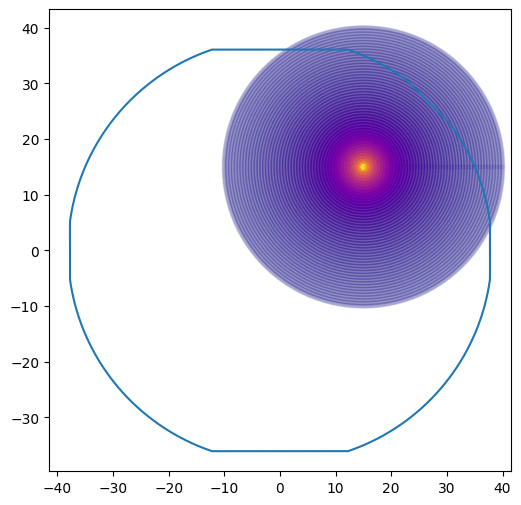

In [9]:
drawDet(litechan)
plt.scatter(flatX,flatY,c=flatZ, cmap=plt.cm.plasma, alpha=0.05, s=9)

In [10]:
def foldedGaussFrame(detShape, hit, radius):
    """Make plot of generalized Gaussian disk in color scale at given
       position, radius.  Uses detector shape to reflect disk at detector
       boundary.  Called from animation frame updater function gaussAtX(i)."""
    alpha=3.5
    beta=0.8
    gx,gy,gz = foldedGauss(detShape, hit, radius, alpha=alpha, beta=beta)

    # Animation code works best with 1D lists, so unroll the np.meshgrid()s
    # generated by foldedGauss (see above)
    flatX = gx.flatten()
    flatY = gy.flatten()
    flatZ = gz.flatten()

    # Color map normalization to apply to Z in every frame
    cmap = matplotlib.cm.plasma
    norm = matplotlib.colors.Normalize(vmin=0., vmax=1.)

    # Magic code to do animation.  Don't know why plt.scatter only called once
    scat = plt.gca().collections
    if len(scat)==0:
        plt.scatter(flatX,flatY,c=norm(flatZ),s=9,cmap=cmap, alpha=0.05)
    else:
        scat[0].set_offsets(np.vstack([flatX,flatY]).transpose())
        scat[0].set_color(cmap(norm(flatZ)))
        
    return plt.gcf()

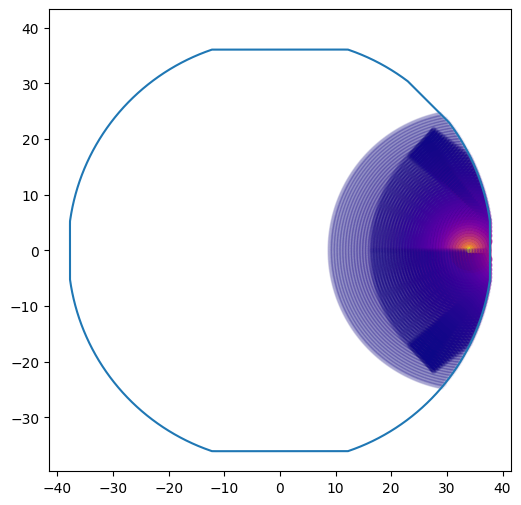

In [13]:
# This animation is based on an answer from StackOverflow:
# https://stackoverflow.com/questions/51017398/how-do-you-add-a-colormap-to-a-matplotlib-animation

def gaussAtX(i):
    """Frame updater, called by animation() with only frame index.  Hit position
       is computed in 2 mm steps from center along 45 degrees."""
    hit = (i*2.,0.)
    radius = 25.
    return foldedGaussFrame(litechan, hit, radius),
    
drawDet(litechan)
nframes = 18       # Will do 2 mm steps of Gaussian disk along X axis
###plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
anim = animation.FuncAnimation(plt.gcf(), gaussAtX, frames=nframes,
                               interval=500., repeat=True, repeat_delay=200., blit=True)
anim.save('reflectedGaussian_movie.gif',writer="pillow")